# Train Bert for extractive summarization and NER

In [1]:
import argparse
from time import time
import torch
import numpy as np
import random
import pandas as pd
from sklearn.utils import shuffle
from transformers import DistilBertTokenizer, DistilBertModel
import statistics
import os
from utils.split_all_docs import split_all_docs
from utils.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from rouge_score import rouge_scorer
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from utils.DataLoader import DataLoader
from utils.preprocess_df import preprocess_df

In [2]:
def is_notebook() -> bool:
  try:
    shell = get_ipython().__class__.__name__
    if shell == 'ZMQInteractiveShell':
      return True   # Jupyter notebook or qtconsole
    elif shell == 'TerminalInteractiveShell':
      return False  # Terminal running IPython
    else:
      return False  # Other type (?)
  except NameError:
    return False      # Probably standard Python interpreter

## (Hyper-)parameters

In [3]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary and ner using bert')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=16)#32)
parser.add_argument('-epochs',type=int,default=100)
parser.add_argument('-dataset',type=str,default="data/wiki_geo_preprocessed.json")
parser.add_argument('-doc_column_name',type=str,default="flat_contents")
parser.add_argument('-labels_sum_column_name',type=str,default="labels_sentences")
parser.add_argument('-labels_ner_column_name',type=str,default="labels_entities")

args = None

if is_notebook():
  args = parser.parse_args("")
else:
  args = parser.parse_args()

In [4]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
bert_layer = DistilBertModel.from_pretrained('distilbert-base-uncased')
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
padding_trunc_doc=512

# hyper-parameters
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 1e-3
early_stopping = 3
model_name = "DistBERT_ExtSUM_NER"
sub_folder_name = "model_name__{}__time__{}__lr__{}__batch_size__{}__cuda_num__{}__early_stopping__{}".format(model_name, time(), learning_rate, batch_size, cuda_num, early_stopping)
checkpoints_folder = "./checkpoints/" + sub_folder_name
loss_sum_coef = 0.5
loss_ner_coef = 0.5
average_number_of_sentences_per_document = 3

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


parse:
is_graphic: True
cuda_num: 0
epochs 100
batch_size 16


## PyTorch initialisation

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
  # Display the number of available GPUs
  print(f"Number of available GPUs: {torch.cuda.device_count()}")
  # Display the name of each GPU
  for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
elif torch.backends.mps.is_available():
  print("MPS available.")
else:
  print("No GPU available.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
elif torch.backends.mps.is_available():
  dev = torch.device("mps")
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Functions

In [8]:
def average(l):
  return sum(l) / len(l)

## Load data

In [9]:
df = pd.read_json(args.dataset)
df = shuffle(df, random_state=0)

df_test = df.iloc[0:1000]
df_val = df.iloc[1000:2000]
df_train = df.iloc[2000:]#300]

In [10]:
# Stats corpus

if False:
  len_articles = []

  for idx in df.index:
    txt = df["flat_contents"][idx]
    txt = sent_tokenize(txt)
    txt = " [SEP] ".join(txt)
    txt = bert_tokenizer.encode(txt, add_special_tokens=False)
    len_articles.append(len(txt))

  print("max:", max(len_articles), ", mediane:", statistics.median(len_articles), ", avg:", average(len_articles), ", std:", statistics.stdev(len_articles))
  # max: 184812 , mediane: 862.5 , avg: 2146.653203237274 , std: 4145.829631357804

In [11]:
df.head(2)

,categories,titles,summaries,contents,entities,flat_contents,trunc_contents,labels_entities,labels_sentences
21430,géologie,Sismicité au Japon,La sismicité au Japon est particulièrement imp...,La sismicité au Japon est particulièrement imp...,"[10 septembre, 11 mars, 12 janvier, 1399, 1400...","\n\n\n\nLe Japon est un archipel volcanique, s...",\n\n\n== Plaques et fosses ==\n\nLe Japon est ...,"[[0, E, 0, 0, E, 0, 0, 0, 0, 0, L, C, C, R, C,...","[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, ..."
7651,géographie générale,Voyage d'études,Voyage d'études est un roman inachevé de l'écr...,Voyage d'études est un roman inachevé de l'écr...,"[1905 en littérature, 1991 en littérature, Abe...","\n\n\n\nEn 1903, Théophile Cart prononce un di...","\n\n\n== Historique ==\n\nEn 1903, Théophile C...","[[0, 0, R, C, 0, 0, 0, 0, E, 0, 0, 0, 0, 0, 0,...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Create dataset and dataloader

In [12]:
train_dataset = preprocess_df(df=df_train, bert_tokenizer=bert_tokenizer, padding_trunc_doc=padding_trunc_doc, doc_column_name="flat_contents", labels_sum_column_name="labels_sentences", entities_column_name="entities", is_sep_n=False)
val_dataset = preprocess_df(df=df_val, bert_tokenizer=bert_tokenizer, padding_trunc_doc=padding_trunc_doc, doc_column_name="flat_contents", labels_sum_column_name="labels_sentences", entities_column_name="entities", is_sep_n=False)
test_dataset = preprocess_df(df=df_test, bert_tokenizer=bert_tokenizer, padding_trunc_doc=padding_trunc_doc, doc_column_name="flat_contents", labels_sum_column_name="labels_sentences", entities_column_name="entities", is_sep_n=False)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model

In [14]:
import torch
import torch.nn as nn

class BertExtSUMNER(nn.Module):
  def __init__(self, bert_layer, bert_tokenizer, dim_emb=768) -> None:
    super(BertExtSUMNER, self).__init__()
    self.bert_layer = bert_layer
    self.bert_tokenizer = bert_tokenizer
    self.dim_emb = dim_emb

    # predict summary
    self.w_sum = nn.Linear(dim_emb, 1)
    
    # NER
    self.w_ner = nn.Linear(dim_emb, 1)

  def forward(self, input_ids, attention_mask):
    x = self.bert_layer(input_ids=input_ids, attention_mask=attention_mask)
    id_sep = bert_tokenizer.sep_token_id
    id_pad = bert_tokenizer.pad_token
    mask_sep = (input_ids == id_sep).view(-1)
    mask_not_sep = ((input_ids != id_sep) & (input_ids != id_pad)).view(-1)
    x = x.last_hidden_state
    x = x.view(-1, self.dim_emb)
    emb_sent = x[mask_sep, :]
    emb_entities = x[mask_not_sep, :]

    o_sum = self.w_sum(emb_sent)
    o_sum = torch.sigmoid(o_sum).squeeze(-1)

    o_ner = self.w_ner(emb_entities)
    o_ner = torch.sigmoid(o_ner).squeeze(-1)

    return o_sum, o_ner

  def save(self, fname):
    torch.save(self.state_dict(), fname)

  def load(self, fname):
    self.load_state_dict(torch.load(fname))

In [15]:
model = BertExtSUMNER(bert_layer=bert_layer, bert_tokenizer=bert_tokenizer)
model = model.to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
criterion = nn.BCELoss()

## Train

In [18]:
if not os.path.exists(checkpoints_folder):
  os.makedirs(checkpoints_folder)

In [19]:
df_val["doc_splitted"] = split_all_docs(df_val[args.doc_column_name])
val_set = df_val
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

/tmp/ipykernel_799511/2083174348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["doc_splitted"] = split_all_docs(df_val[args.doc_column_name])


In [20]:
import math

arr_train_loss = []
arr_train_loss_sum = []
arr_train_loss_ner = []
arr_train_acc_sum = []
arr_train_acc_ner = []
arr_val_loss = []
arr_val_acc_sum = []
arr_val_acc_ner = []

t1 = time()

for epoch in range(1, epochs+1):
  # Train
  model.train()
  nb_batch_train = 0
  total_train_loss = 0
  total_train_loss_sum = 0
  total_train_loss_ner = 0
  total_train_acc_sum = 0
  total_train_acc_ner = 0
  
  id_sep = bert_tokenizer.sep_token_id
  id_pad = bert_tokenizer.pad_token

  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for batch in tepoch:
      tepoch.set_description(f"Epoch {epoch}")
      #if dev != "cpu":
      #  torch.cuda.empty_cache()
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets_sum = torch.tensor(batch["labels_sum"], dtype=torch.float).to(device)
      targets_ner = torch.tensor(batch["labels_ner"], dtype=torch.float).to(device)[(input_ids.view(-1) != id_sep) & (input_ids.view(-1) != id_pad)]
      
      y_sum_pred, y_ner_pred = model(input_ids, attention_mask)

      loss_sum = criterion(y_sum_pred, targets_sum)
      loss_ner = criterion(y_ner_pred, targets_ner)
      
      loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner
      
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      nb_batch_train += 1
      total_train_loss += loss.item()
      total_train_loss_sum += loss_sum.item()
      total_train_loss_ner += loss_ner.item()

      probs = y_sum_pred.tolist() # compute_probs(y_pred)
      probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

      doc_lens = torch.sum(input_ids == id_sep, dim=1).tolist()
      total_train_acc_sum += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets_sum.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)
      total_train_acc_ner += torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0]

      tepoch.set_postfix(loss=total_train_loss/nb_batch_train, loss_sum=total_train_loss_sum/nb_batch_train, loss_ner=total_train_loss_ner/nb_batch_train, accuracy_sum=total_train_acc_sum/nb_batch_train, accuracy_ner=total_train_acc_ner/nb_batch_train)

  # Save model
  model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")

  # Eval
  model.eval()
  nb_batch_val = 0
  total_val_loss = 0
  total_val_loss_sum = 0
  total_val_loss_ner = 0
  total_val_acc_sum = 0
  total_val_acc_ner = 0
  total_r1 = 0
  total_r2 = 0
  total_rl = 0

  del loss
  del loss_sum
  del loss_ner
  del y_sum_pred
  del y_ner_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  for i, batch in enumerate(val_loader):
    #if dev != "cpu":
    #  torch.cuda.empty_cache()
    input_ids = batch["input_ids"].to(device)
    attention_mask = torch.tensor(batch["attention_mask"], dtype=torch.long).to(device)
    targets_sum = torch.tensor(batch["labels_sum"], dtype=torch.float).to(device)
    targets_ner = torch.tensor(batch["labels_ner"], dtype=torch.float).to(device)[(input_ids.view(-1) != id_sep) & (input_ids.view(-1) != id_pad)]

    y_sum_pred, y_ner_pred = model(input_ids, attention_mask)

    loss_sum = criterion(y_sum_pred, targets_sum)
    loss_ner = criterion(y_ner_pred, targets_ner)
    
    loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner

    nb_batch_val += 1
    total_val_loss += loss.item()
    total_val_loss_sum += loss_sum.item()
    total_val_loss_ner += loss_ner.item()

    doc = val_set["doc_splitted"].iloc[i]
    summaries = val_set["summaries"].iloc[i]

    indices = torch.argsort(y_sum_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    doc_lens = torch.sum(input_ids == id_sep, dim=1).tolist()
    for j in range(doc_lens[0]):
      txt = txt + ". " + doc[indices[j]]
      y_pred_thresh.append(indices[j])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for j in y_pred_thresh:
      txt = txt + ". " + doc[j]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    scores = scorer.score(summaries, txt)
    total_r1 += scores["rouge1"].recall
    total_r2 += scores["rouge2"].recall
    total_rl += scores["rougeL"].recall

    probs = y_sum_pred.tolist() # compute_probs(y_pred)
    probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

    total_val_acc_sum += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets_sum.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)
    total_val_acc_ner += torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0]

  print("Epoch {} : val loss = {:.3f}, val loss summary = {:.3f}, val loss ner = {:.3f}, val accuracy summary = {:.3f}, val accuracy ner = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_loss_sum / nb_batch_val, total_val_loss_ner / nb_batch_val, total_val_acc_sum / nb_batch_val, total_val_acc_ner / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))

  if len(arr_val_loss) >= early_stopping+1:
    if min(arr_val_loss[-early_stopping:]) >= arr_val_loss[-(early_stopping+1)]:
      break

  del loss
  del loss_sum
  del loss_ner
  del y_sum_pred
  del y_ner_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  arr_train_loss.append(total_train_loss / nb_batch_train)
  
  arr_train_acc_sum.append(total_train_acc_sum / nb_batch_train)
  arr_train_acc_ner.append(total_train_acc_ner / nb_batch_train)

  arr_val_loss.append(total_val_loss / nb_batch_val)
  arr_val_acc_sum.append(total_val_acc_sum / nb_batch_val)
  arr_val_acc_ner.append(total_val_acc_ner / nb_batch_val)

t2 = time()
print("Training duration =", t2-t1)

Epoch 1: 100%|██████████| 1528/1528 [13:50<00:00,  1.84batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.359, loss_ner=0.0207, loss_sum=0.697]
/tmp/ipykernel_799511/3688086596.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch["attention_mask"], dtype=torch.long).to(device)


Epoch 1 : val loss = 0.356, val loss summary = 0.694, val loss ner = 0.018, val accuracy summary = 0.701, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 2: 100%|██████████| 1528/1528 [14:33<00:00,  1.75batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.0201, loss_sum=0.694]


Epoch 2 : val loss = 0.354, val loss summary = 0.690, val loss ner = 0.018, val accuracy summary = 0.701, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 3: 100%|██████████| 1528/1528 [14:26<00:00,  1.76batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.0201, loss_sum=0.693]


Epoch 3 : val loss = 0.354, val loss summary = 0.690, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 4: 100%|██████████| 1528/1528 [14:25<00:00,  1.77batch/s, accuracy_ner=0.997, accuracy_sum=0.488, loss=0.357, loss_ner=0.0201, loss_sum=0.693]


Epoch 4 : val loss = 0.357, val loss summary = 0.695, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 5: 100%|██████████| 1528/1528 [14:20<00:00,  1.77batch/s, accuracy_ner=0.996, accuracy_sum=0.489, loss=0.362, loss_ner=0.0286, loss_sum=0.695]


Epoch 5 : val loss = 0.353, val loss summary = 0.688, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 6: 100%|██████████| 1528/1528 [14:29<00:00,  1.76batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.0201, loss_sum=0.694]


Epoch 6 : val loss = 0.356, val loss summary = 0.693, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 7: 100%|██████████| 1528/1528 [14:29<00:00,  1.76batch/s, accuracy_ner=0.997, accuracy_sum=0.488, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 7 : val loss = 0.355, val loss summary = 0.693, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 8: 100%|██████████| 1528/1528 [14:29<00:00,  1.76batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.0201, loss_sum=0.693]


Epoch 8 : val loss = 0.352, val loss summary = 0.687, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 9: 100%|██████████| 1528/1528 [14:24<00:00,  1.77batch/s, accuracy_ner=0.997, accuracy_sum=0.488, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 9 : val loss = 0.354, val loss summary = 0.691, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 10: 100%|██████████| 1528/1528 [14:19<00:00,  1.78batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 10 : val loss = 0.352, val loss summary = 0.686, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 11: 100%|██████████| 1528/1528 [14:12<00:00,  1.79batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 11 : val loss = 0.353, val loss summary = 0.687, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 12: 100%|██████████| 1528/1528 [13:57<00:00,  1.83batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 12 : val loss = 0.352, val loss summary = 0.686, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 13: 100%|██████████| 1528/1528 [13:56<00:00,  1.83batch/s, accuracy_ner=0.997, accuracy_sum=0.488, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 13 : val loss = 0.353, val loss summary = 0.687, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 14: 100%|██████████| 1528/1528 [13:58<00:00,  1.82batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 14 : val loss = 0.355, val loss summary = 0.692, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 15: 100%|██████████| 1528/1528 [13:56<00:00,  1.83batch/s, accuracy_ner=0.997, accuracy_sum=0.488, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 15 : val loss = 0.350, val loss summary = 0.683, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 16: 100%|██████████| 1528/1528 [13:56<00:00,  1.83batch/s, accuracy_ner=0.997, accuracy_sum=0.488, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 16 : val loss = 0.352, val loss summary = 0.685, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 17: 100%|██████████| 1528/1528 [13:56<00:00,  1.83batch/s, accuracy_ner=0.997, accuracy_sum=0.488, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 17 : val loss = 0.352, val loss summary = 0.687, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151


Epoch 18: 100%|██████████| 1528/1528 [13:56<00:00,  1.83batch/s, accuracy_ner=0.997, accuracy_sum=0.49, loss=0.357, loss_ner=0.02, loss_sum=0.693]   


Epoch 18 : val loss = 0.352, val loss summary = 0.685, val loss ner = 0.018, val accuracy summary = 0.701, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.150


Epoch 19: 100%|██████████| 1528/1528 [13:55<00:00,  1.83batch/s, accuracy_ner=0.997, accuracy_sum=0.489, loss=0.357, loss_ner=0.02, loss_sum=0.693]  


Epoch 19 : val loss = 0.353, val loss summary = 0.687, val loss ner = 0.018, val accuracy summary = 0.702, val accuracy ner = 0.997, r1 = 0.243, r2 = 0.058, rL = 0.151
Training duration = 16485.63907980919


In [21]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_acc_sum"]  = arr_train_acc_sum
training_metrics["train_acc_ner"]  = arr_train_acc_ner
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_acc_sum"]    = arr_val_acc_sum
training_metrics["val_acc_ner"]    = arr_val_acc_ner

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
  json.dump(training_metrics, fp)

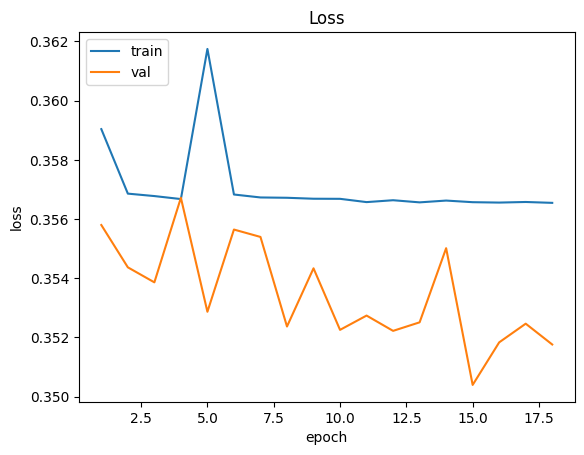

In [22]:
# draw Losses
if is_graphic:
  plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
  plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

  plt.title("Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(loc="upper left")

  plt.show()

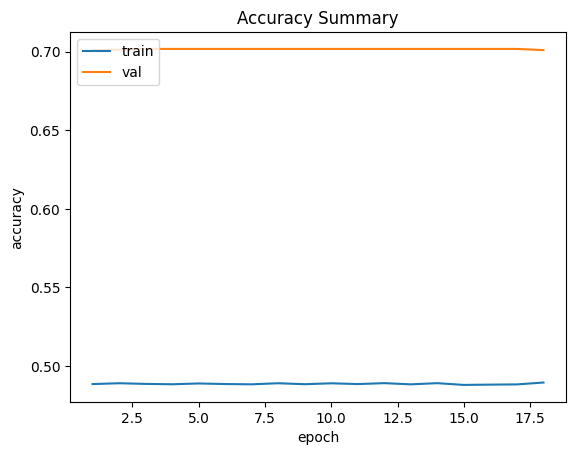

In [23]:
# draw Accuracies
if is_graphic:
  plt.plot(list(range(1, len(arr_train_acc_sum) + 1)), arr_train_acc_sum, label="train")
  plt.plot(list(range(1, len(arr_val_acc_sum) + 1)), arr_val_acc_sum, label="val")

  plt.title("Accuracy Summary")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

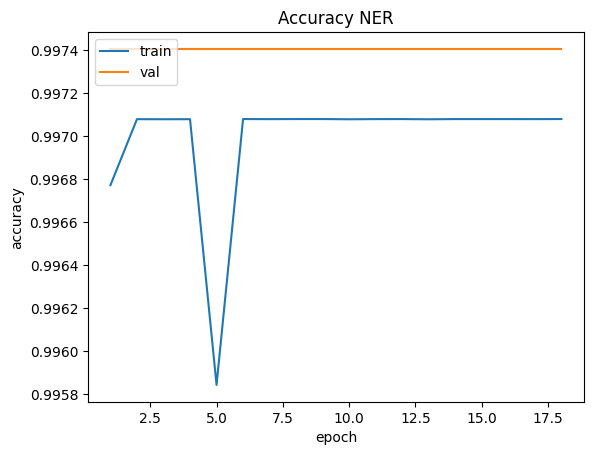

In [24]:
# draw Accuracies
if is_graphic:
  plt.plot(list(range(1, len(arr_train_acc_ner) + 1)), arr_train_acc_ner, label="train")
  plt.plot(list(range(1, len(arr_val_acc_ner) + 1)), arr_val_acc_ner, label="val")

  plt.title("Accuracy NER")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

## Eval Model

In [25]:
model = BertExtSUMNER(bert_layer=bert_layer, bert_tokenizer=bert_tokenizer)

In [26]:
best_epoch = np.argmin(np.array(arr_val_loss)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()
best_epoch

15

In [27]:
df_test["doc_splitted"] = split_all_docs(df_test[args.doc_column_name], False)
test_set = df_test

/tmp/ipykernel_799511/1937099444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["doc_splitted"] = split_all_docs(df_test[args.doc_column_name], False)


In [28]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
criterion = nn.BCELoss()

In [29]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
arr_loss = []
arr_loss_sum = []
arr_loss_ner = []
accuracy_sum = []
accuracy_ner = []

idx = 0

counter = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
  for batch in tepoch:
    tepoch.set_description("Eval model")
    input_ids = batch["input_ids"].to(device)
    attention_mask = torch.tensor(batch["attention_mask"], dtype=torch.float).to(device)
    targets_sum = torch.tensor(batch["labels_sum"], dtype=torch.float).to(device)
    targets_ner = torch.tensor(batch["labels_ner"], dtype=torch.float).to(device)[(input_ids.view(-1) != id_sep) & (input_ids.view(-1) != id_pad)]

    y_sum_pred, y_ner_pred = model(input_ids, attention_mask)

    loss_sum = criterion(y_sum_pred, targets_sum)
    loss_ner = criterion(y_ner_pred, targets_ner)
    
    loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner

    arr_loss.append(loss.item())
    arr_loss_sum.append(loss_sum.item())
    arr_loss_ner.append(loss_ner.item())

    doc = test_set["doc_splitted"].iloc[idx]
    summaries = test_set["summaries"].iloc[idx]

    probs = np.array(y_sum_pred.tolist()) # compute_probs(y_pred)
    probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

    #probs = threshold_probs_by_nb(probs=probs, doc_lens=[probs.shape[0]], average_number_of_sentences_per_document=average_number_of_sentences_per_document)
    #probs = threshold_probs_by_prop(probs=probs, doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document)
    indices = torch.argsort(y_sum_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    for i in range(min(len(doc), y_sum_pred.shape[0])):
      txt = txt + ". " + doc[indices[i]]
      y_pred_thresh.append(indices[i])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for i in y_pred_thresh:#range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[i]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    # assert len(txt) - len(summaries) <= 20

    scores = scorer.score(summaries, txt)
    arr_rouge1.append(scores["rouge1"].recall)
    arr_rouge2.append(scores["rouge2"].recall)
    arr_rougeL.append(scores["rougeL"].recall)

    accuracy_sum.append(accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets_sum.cpu().detach().numpy(), doc_lens=[len(probs)], average_number_of_sentences_per_document=average_number_of_sentences_per_document))
    #accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document))
    accuracy_ner.append(torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0])

    tepoch.set_postfix(loss=average(arr_loss), loss_sum=average(arr_loss_sum), loss_ner=average(arr_loss_ner), rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL), accuracy_sum=average(accuracy_sum), accuracy_ner=average(accuracy_ner))
    idx += 1

Eval model:   0%|          | 0/1000 [00:00<?, ?batch/s]/tmp/ipykernel_799511/1945662248.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch["attention_mask"], dtype=torch.float).to(device)
Eval model: 100%|██████████| 1000/1000 [00:17<00:00, 57.91batch/s, accuracy_ner=0.997, accuracy_sum=0.695, loss=0.352, loss_ner=0.0206, loss_sum=0.684, rouge1=0.249, rouge2=0.0613, rougeL=0.152]


In [30]:
test_metrics = {}
test_metrics["accuracy_sum"] = average(accuracy_sum)
test_metrics["accuracy_ner"] = average(accuracy_ner)
test_metrics["rouge1"]   = average(arr_rouge1)
test_metrics["rouge2"]   = average(arr_rouge2)
test_metrics["rougeL"]   = average(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
  json.dump(test_metrics, fp)

## Lead-3

In [31]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Lead-3")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(min(len(doc), 3)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        # assert len(txt) - len(summaries) <= 20

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL))

Lead-3: 100%|██████████| 1000/1000 [00:03<00:00, 256.90batch/s, rouge1=0.266, rouge2=0.0809, rougeL=0.176]


## First n char

In [32]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("First-n-char'")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(len(doc)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = average(arr_rouge1), rouge2 = average(arr_rouge2), rougeL = average(arr_rougeL))

First-n-char': 100%|██████████| 1000/1000 [00:05<00:00, 171.10batch/s, rouge1=0.3, rouge2=0.0901, rougeL=0.188] 


In [33]:
# Does not execute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/rsaid/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
torch.sum(train_dataset[0]["input_ids"] == 102)

tensor(18)

In [ ]:
len(train_dataset[0]["labels_sum"])

18

In [ ]:
print(train_dataset[0]["input_ids"].tolist())

[2474, 5715, 9765, 8740, 13926, 1011, 9765, 4241, 17155, 16778, 2078, 1012, 102, 2365, 8945, 12514, 9765, 1037, 1016, 1010, 1019, 2463, 1037, 1048, 1005, 9765, 2139, 3002, 1011, 5578, 1011, 1041, 25394, 3366, 3802, 1037, 1022, 2463, 1037, 1048, 1005, 15068, 4355, 2139, 3347, 21031, 3126, 1012, 102, 3393, 18856, 9581, 2102, 21864, 14418, 21162, 5562, 2474, 5715, 9765, 24209, 11475, 8873, 2063, 1010, 4372, 2230, 1010, 2139, 1077, 18856, 9581, 2102, 4153, 7413, 23151, 2278, 1090, 1010, 7367, 7811, 2474, 5939, 18155, 8649, 2666, 4078, 18856, 9581, 3215, 2139, 2474, 2605, 21864, 4012, 13876, 2063, 2632, 5668, 17504, 2102, 2882, 2015, 4127, 2139, 18856, 9581, 3215, 4372, 6005, 15049, 1012, 102, 4372, 12609, 1010, 2474, 5715, 24501, 21748, 2102, 4241, 2828, 1077, 18856, 9581, 2102, 4153, 7413, 1090, 18033, 2474, 5579, 27859, 16558, 2666, 11968, 2777, 8780, 1011, 2605, 1010, 21864, 11265, 4012, 13876, 2063, 4078, 2953, 2863, 2483, 1010, 4372, 6765, 10439, 3217, 5403, 1010, 10861, 25022, 2078, 

In [ ]:
df_train["flat_contents"][df_train.index[0]]

"\n\n\nLa commune est au nord-est du Cotentin. Son bourg est à 2,5 km à l'est de Saint-Pierre-Église et à 8 km à l'ouest de Barfleur.\n\n\nLe climat qui caractérise la commune est qualifié, en 2010, de « climat océanique franc », selon la typologie des climats de la France qui compte alors huit grands types de climats en métropole. En 2020, la commune ressort du type « climat océanique » dans la classification établie par Météo-France, qui ne compte désormais, en première approche, que cinq grands types de climats en métropole. Ce type de climat se traduit par des températures douces et une pluviométrie relativement abondante (en liaison avec les perturbations venant de l'Atlantique), répartie tout au long de l'année avec un léger maximum d'octobre à février.\nLes paramètres climatiques qui ont permis d’établir la typologie de 2010 comportent six variables pour les températures et huit pour les précipitations, dont les valeurs correspondent à la normale 1971-2000. Les sept principales 

In [ ]:
bert_tokenizer.encode("Saint-Pierre-Église", add_special_tokens=False)

[3002, 1011, 5578, 1011, 1041, 25394, 3366]

In [ ]:
train_dataset[0]["labels_ner"]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
for i in range(len(train_dataset)):
  print(sum(train_dataset[i]["labels_ner"]))

2
1
1
2
2
3
3
2
0
2
2
2
4
5
2
0
5
1
8
0
0
1
7
0
0
6
2
6
4
2
0
3
0
1
0
1
1
0
0
3
1
4
1
10
2
0
1
1
5
4
2
5
8
3
4
1
3
1
4
4
2
0
4
1
0
2
9
0
0
4
4
3
0
2
5
7
3
4
1
6
0
1
2
0
4
14
0
3
0
1
0
0
1
1
0
1
2
3
0
4


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
sep_token_id = tokenizer.sep_token_id

print(f"ID du token [SEP]: {sep_token_id}")

ID du token [SEP]: 102


In [ ]:
for i in range(len(train_dataset)):
  print(len(train_dataset[0]["input_ids"]))

1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
